In [2]:
# Import math and statistics libraries
import numpy as np

# Import data manipulation libraries
import pandas as pd

# Import graphing libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Import system libraries
import os
import sys
from dotenv import load_dotenv

# # Import Polygon.io client for financial data
# from polygon import RESTClient

sys.path.append(os.path.abspath(os.path.join('..', 'src')))
from os_lib import OSLib # type: ignore
# from polygon_api import PolygonAPI

In [3]:
# Get the API key from environment variables
load_dotenv()
api_key = os.getenv('POLYGON_API_KEY')

In [4]:
# Tickers from a selection of the S&P 500 companies
tickers = ['AAPL', 'MSFT', 'GOOGL', 'IBM', 'AMZN', 'NVDA',
          'XOM', 'CVX', 'WMT', 'MMM', 'ARE', 'ALLE', 'JPM',
          'V', 'MA', 'PEP', 'CSCO', 'BA', 'ADBE', 'CAT', 
          'BLK', 'INTC', 'NKE', 'MDLZ']

In [5]:
# Import custom lib
oslib = OSLib

# Get the root path of the repository
repo_path = oslib.get_root_path()


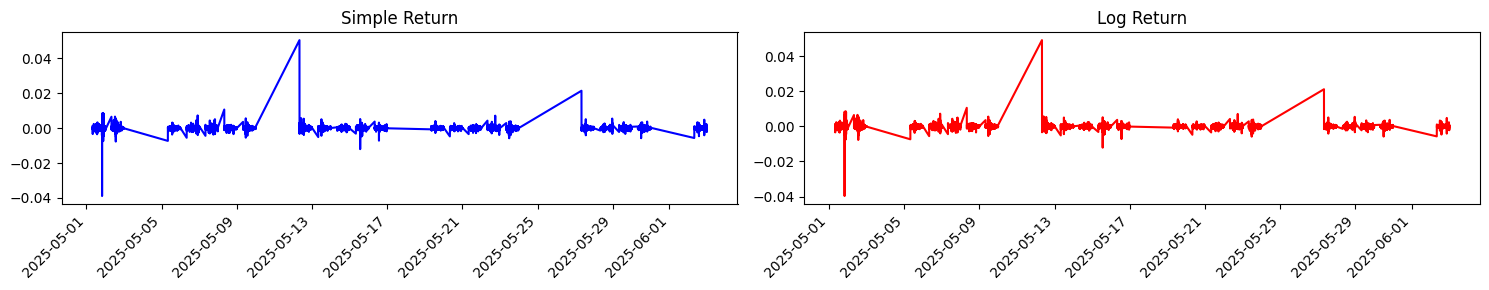

Simple Return: 0.0005 %
Log Return: 0.00045 %


In [6]:
source_path = repo_path + "/data/polygon/intraday/amzn/"

amzn = pd.read_parquet(source_path)
amzn.sort_index(inplace=True)

amzn['simple_return'] = (amzn['close'] / amzn['close'].shift(1)) - 1
amzn['log_return'] = np.log(amzn['close'] / amzn['close'].shift(1))

fig, axes = plt.subplots(1, 2, figsize=(15, 3), sharex=True)
amzn['simple_return'].plot(ax=axes[0], title='Simple Return', color='blue')
amzn['log_return'].plot(ax=axes[1], title='Log Return', color='red')

for ax in axes:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

plt.tight_layout()
plt.show()

print(f"Simple Return: {round(amzn['simple_return'].mean() * 100, 5)} %")
print(f"Log Return: {round(amzn['log_return'].mean() * 100, 5)} %")

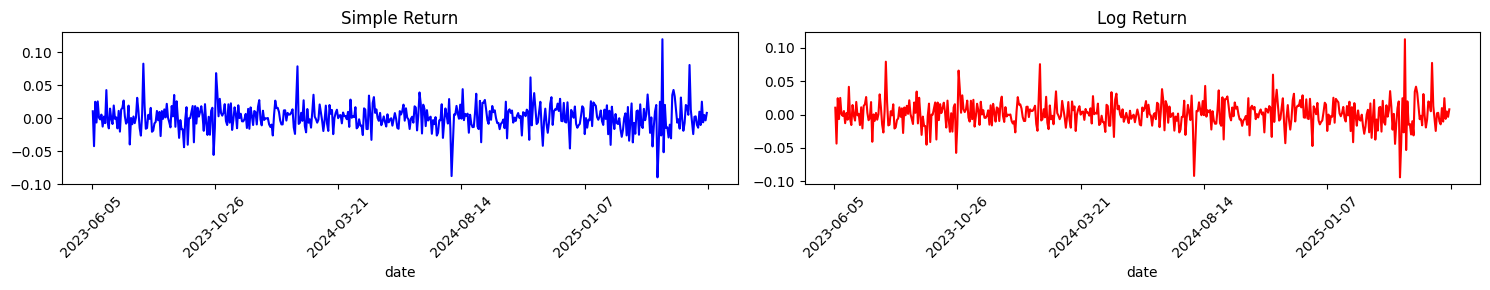

Simple Return: 0.11998 %
Log Return: 0.10026 %


In [7]:
source_path = repo_path + "/data/polygon/daily/amzn/"

amzn_daily = pd.read_parquet(source_path)
amzn_daily.index = pd.to_datetime(amzn_daily.index).strftime('%Y-%m-%d')

amzn_daily['simple_return'] = (amzn_daily['close'] / amzn_daily['close'].shift(1)) - 1

amzn_daily['log_return'] = np.log(amzn_daily['close'] / amzn_daily['close'].shift(1))

fig, axes = plt.subplots(1, 2, figsize=(15, 3), sharex=True)
amzn_daily['simple_return'].plot(ax=axes[0], title='Simple Return', color='blue')
amzn_daily['log_return'].plot(ax=axes[1], title='Log Return', color='red')

for ax in axes:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

plt.tight_layout()
plt.show()

print(f"Simple Return: {round(amzn_daily['simple_return'].mean() * 100, 5)} %")
print(f"Log Return: {round(amzn_daily['log_return'].mean() * 100, 5)} %")

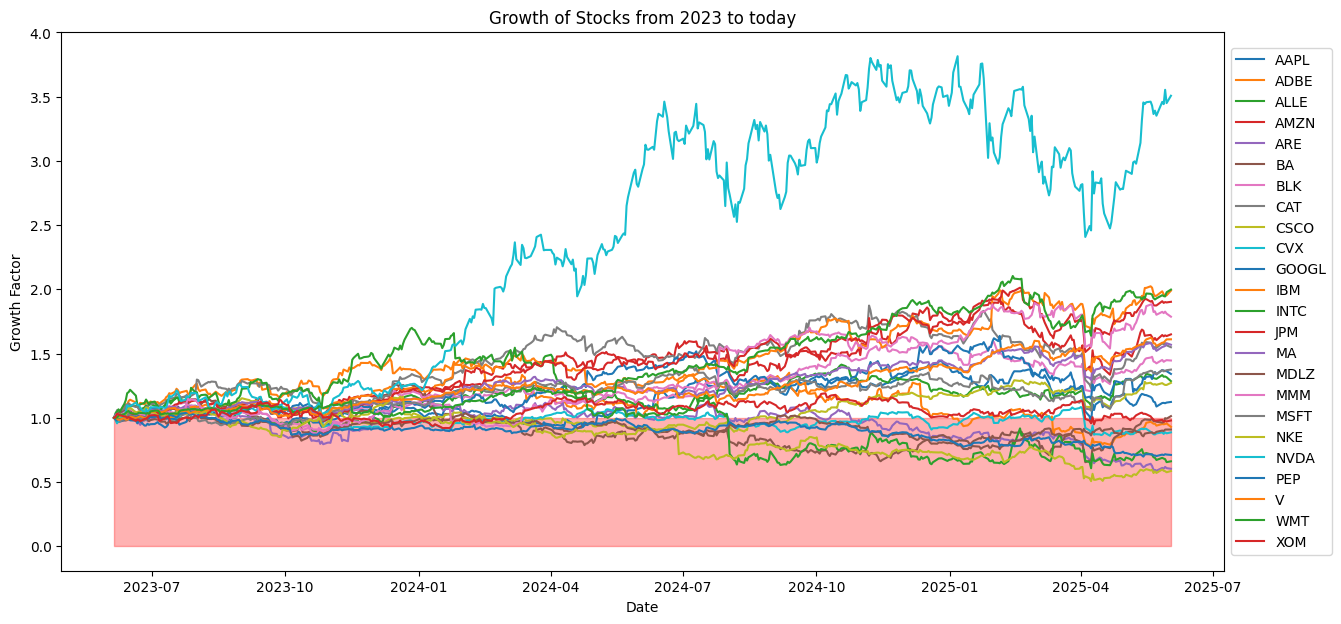

In [8]:
source_daily_path = repo_path + "/data/polygon/daily/"


df = pd.DataFrame()
simple_returns = pd.DataFrame()

plt.figure(figsize=(15, 7))

for ticker in os.listdir(source_daily_path):
    df[ticker] = pd.read_parquet(source_daily_path + ticker + "/")['close']
    simple_returns[ticker] = (df[ticker] / df[ticker].shift(1)) - 1
    growth = (df[ticker] / df[ticker].iloc[0])
    plt.plot(df.index, growth, label=ticker.upper())

thres = 1.0

plt.fill_between(df.index, thres, 0, where=(df[ticker] > thres), color='red', alpha=0.3)
plt.title('Growth of Stocks from 2023 to today')
plt.xlabel('Date')
plt.ylabel('Growth Factor')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

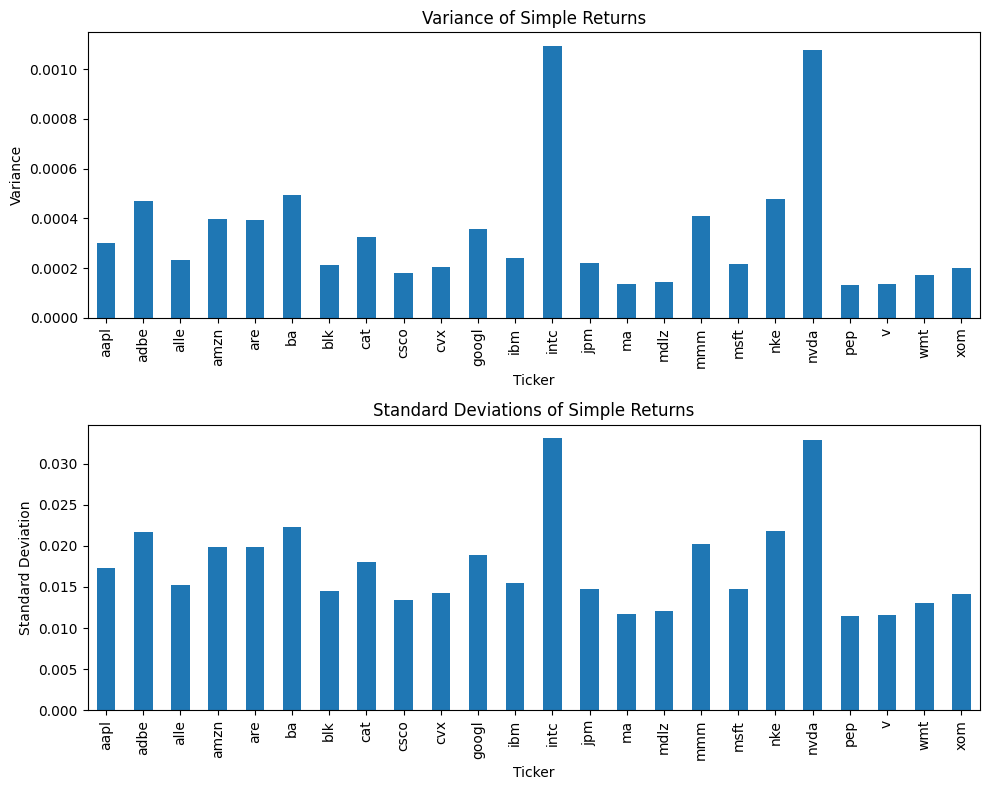

In [9]:
# Create a figure and two subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Plot variance of returns
simple_returns.var().plot(kind='bar', ax=axs[0], title='Variance of Simple Returns')
axs[0].set_xlabel('Ticker')
axs[0].set_ylabel('Variance')

# Plot standard deviation of returns
simple_returns.std().plot(kind='bar', ax=axs[1], title='Standard Deviations of Simple Returns')
axs[1].set_xlabel('Ticker')
axs[1].set_ylabel('Standard Deviation')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


<Axes: >

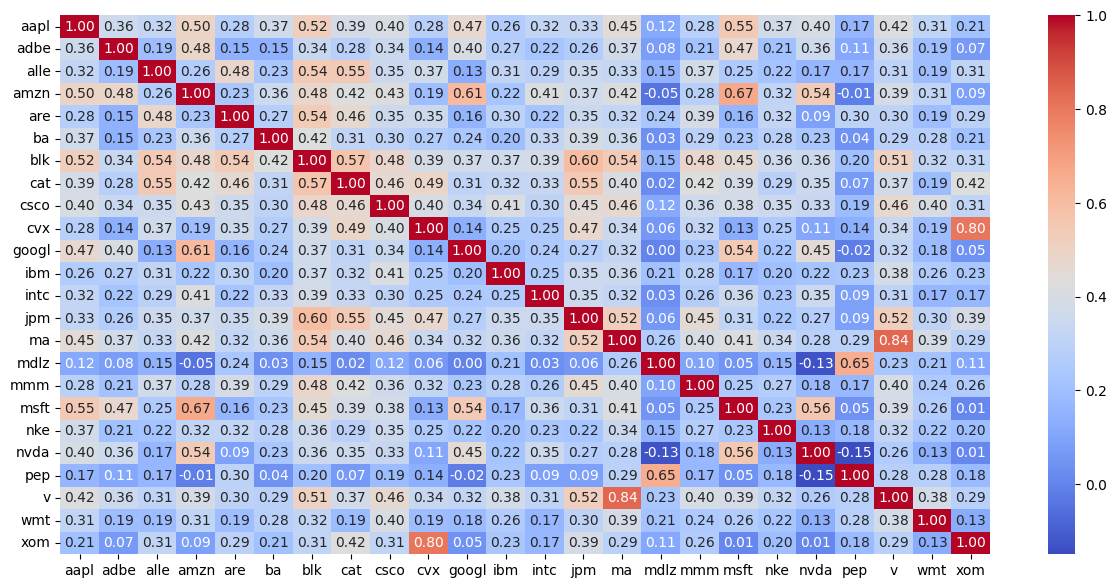

In [10]:
plt.figure(figsize=(15, 7))
sns.heatmap(simple_returns.corr(), annot=True, cmap='coolwarm', fmt='.2f')

In [11]:
# Setting weight for equal distribution among tickers
equal_ws = np.array([1/len(tickers) for _ in tickers])

In [12]:
pfolio_returns = simple_returns.dot(equal_ws)
pfolio_var = np.dot(equal_ws.T, np.dot(simple_returns.cov(), equal_ws))
print(f"Portfolio Returns: {round(pfolio_returns.mean() * 100, 5)} %")
print(f"Portfolio Variance: {pfolio_var}")

Portfolio Returns: 0.06072 %
Portfolio Variance: 0.00010005966643612625


## Aggregate DataFrame

### Dividend Yield & Returns in 2024

In [ ]:
source_dividends_path = repo_path + "/data/polygon/dividends/"
divs = pd.read_parquet(source_dividends_path)

# Calculate average dividend payout per share per ticker in 2024
sum_divs = divs[(divs.index >= '2024-01-01') & (divs.index < '2025-01-01')][['ticker', 'cash_amount']].groupby('ticker').sum()
sum_divs = sum_divs.rename(columns={'cash_amount': 'total_dividend_2024'})

,total_dividend_2024
ticker,
AAPL,0.99
ALLE,1.92
ARE,5.19
BLK,20.40
CAT,5.42


In [ ]:
# Calculate the average share price for each ticker in 2024
avg_price_df = pd.DataFrame()

for ticker in os.listdir(source_daily_path):
    ticker_df = pd.read_parquet(source_daily_path + ticker + "/")
    avg_price_2024 = ticker_df[(ticker_df.index >= '2024-01-01') & (ticker_df.index < '2025-01-01')]['close'].mean()
    avg_price_df.loc[ticker.upper(), 'avg_price_2024'] = avg_price_2024
    avg_price_df.loc[ticker.upper(), 'returns_2024_%'] = (ticker_df['close'].iloc[-1] / ticker_df['close'].iloc[0]) - 1

In [20]:
# join the dfs on the index
agg_12mnd_df = sum_divs.join(avg_price_df, how='inner')

# Calculate the dividend yield for each ticker
agg_12mnd_df['dividend_yield_%_2024'] = (agg_12mnd_df['total_dividend_2024'] / agg_12mnd_df['avg_price_2024']) * 100

agg_12mnd_df.sort_values(by='dividend_yield_%_2024', ascending=False).head(10)

,total_dividend_2024,avg_price_2024,returns_2024,dividend_yield_%_2024
ARE,5.19,117.724762,-0.397037,4.408588
CVX,6.52,153.067937,-0.113626,4.259547
IBM,6.67,193.956389,0.989596,3.438917
XOM,3.84,113.476548,-0.021275,3.383959
MMM,3.61,108.840254,0.787042,3.316788
PEP,5.33,169.141111,-0.289267,3.151215
CSCO,1.59,50.803730,0.271659,3.129691
MDLZ,1.79,69.468333,-0.091264,2.576714
BLK,20.40,867.082500,0.445801,2.352717
JPM,4.60,205.201111,0.902797,2.241703


In [ ]:
agg_12mnd_df.sort_values(by='returns_2024_%', ascending=False).head(10)

,total_dividend_2024,avg_price_2024,returns_2024,dividend_yield_%_2024
NVDA,0.07,107.825438,2.507186,0.064920
WMT,0.83,70.283651,0.998065,1.180929
IBM,6.67,193.956389,0.989596,3.438917
JPM,4.60,205.201111,0.902797,2.241703
MMM,3.61,108.840254,0.787042,3.316788
V,2.15,280.384206,0.610971,0.766805
MA,2.64,474.129286,0.568660,0.556810
CAT,5.42,350.250714,0.549288,1.547463
BLK,20.40,867.082500,0.445801,2.352717
MSFT,3.08,420.312302,0.375156,0.732788
